Final Balance: 10336.610000000017


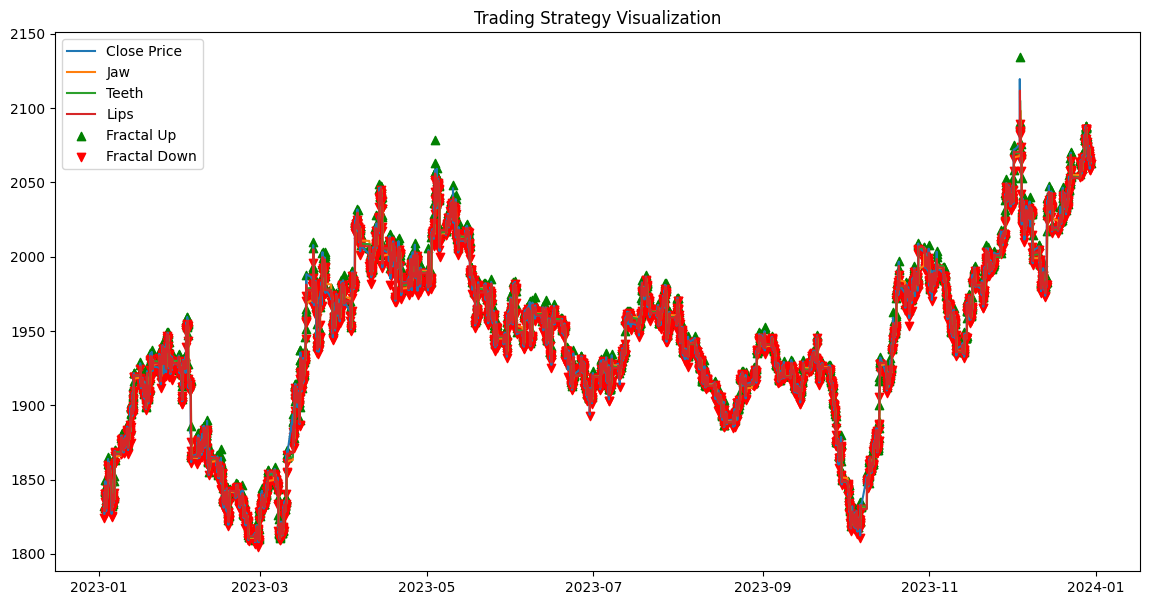

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime
from ta.volume import MFIIndicator
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize MT5 connection
mt5.initialize()

# Define the symbol and timeframe
symbol = "XAUUSD"
timeframe = mt5.TIMEFRAME_M15
start = datetime(2023, 1, 1)
end = datetime(2024, 1, 1)

# Fetch historical data
rates = mt5.copy_rates_range(symbol, timeframe, start, end)
data = pd.DataFrame(rates)
data['time'] = pd.to_datetime(data['time'], unit='s')

mt5.shutdown()

# Alligator Indicator
def alligator(data, jaw_length=13, teeth_length=8, lips_length=5, jaw_offset=8, teeth_offset=5, lips_offset=3):
    data['jaw'] = data['close'].rolling(window=jaw_length).mean().shift(jaw_offset)
    data['teeth'] = data['close'].rolling(window=teeth_length).mean().shift(teeth_offset)
    data['lips'] = data['close'].rolling(window=lips_length).mean().shift(lips_offset)
    return data

# Stochastic Oscillator
def stochastic(data, k_period=14, d_period=3):
    data['low_k'] = data['low'].rolling(window=k_period).min()
    data['high_k'] = data['high'].rolling(window=k_period).max()
    data['%K'] = 100 * (data['close'] - data['low_k']) / (data['high_k'] - data['low_k'])
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    return data

# ATR Indicator
def atr(data, atr_period=14):
    data['hl'] = data['high'] - data['low']
    data['hc'] = abs(data['high'] - data['close'].shift(1))
    data['lc'] = abs(data['low'] - data['close'].shift(1))
    data['tr'] = data[['hl', 'hc', 'lc']].max(axis=1)
    data['atr'] = data['tr'].rolling(window=atr_period).mean()
    return data

# Fractals
def fractals(data, n=2):
    data['fractal_up'] = data['high'][(data['high'] > data['high'].shift(1)) & (data['high'] > data['high'].shift(-1))]
    data['fractal_down'] = data['low'][(data['low'] < data['low'].shift(1)) & (data['low'] < data['low'].shift(-1))]
    return data

# Machine Learning Enhanced MFI
def ml_mfi(data, mfi_length=14, train_length=300, iterations=5):
    mfi = MFIIndicator(high=data['high'], low=data['low'], close=data['close'], volume=data['tick_volume'], window=mfi_length).money_flow_index()
    data['mfi'] = mfi

    def kmeans_adjust(data, iterations, train_length):
        kmeans = KMeans(n_clusters=3)
        for i in range(iterations):
            sample = data['mfi'].iloc[-train_length:]
            kmeans.fit(sample.values.reshape(-1, 1))
            centers = sorted(kmeans.cluster_centers_.flatten())
            data['overbought'], data['neutral'], data['oversold'] = centers[2], centers[1], centers[0]
            data['mfi'] = data['mfi'].apply(lambda x: (x - centers[0]) / (centers[2] - centers[0]) * 100)

        return data

    data = kmeans_adjust(data, iterations, train_length)
    return data

# Apply Indicators and Strategy Logic
def apply_strategy(data):
    # Apply indicators
    data = alligator(data)
    data = stochastic(data)
    data = atr(data)
    data = fractals(data)
    data = ml_mfi(data)

    # Define strategy conditions
    data['buy_signal'] = (data['close'] > data['lips']) & (data['mfi'] < 20) & (data['%K'] > data['%D'])
    data['sell_signal'] = (data['close'] < data['lips']) & (data['mfi'] > 80) & (data['%K'] < data['%D'])

    # ATR trailing stop loss
    data['trail_stop'] = data['atr'] * 1.75

    return data

data = apply_strategy(data)

# Backtesting
def backtest(data, initial_balance=10000):
    balance = initial_balance
    position = 0
    entry_price = 0

    for i in range(len(data)):
        if data['buy_signal'].iloc[i] and position == 0:
            position = 1
            entry_price = data['close'].iloc[i]
            stop_loss = entry_price - data['trail_stop'].iloc[i]

        elif data['sell_signal'].iloc[i] and position == 1:
            balance += (data['close'].iloc[i] - entry_price)
            position = 0

        elif position == 1 and data['close'].iloc[i] < stop_loss:
            balance += (data['close'].iloc[i] - entry_price)
            position = 0

    return balance

final_balance = backtest(data)
print(f"Final Balance: {final_balance}")

# Visualization
def plot_strategy(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data['time'], data['close'], label='Close Price')
    plt.plot(data['time'], data['jaw'], label='Jaw')
    plt.plot(data['time'], data['teeth'], label='Teeth')
    plt.plot(data['time'], data['lips'], label='Lips')
    plt.scatter(data['time'], data['fractal_up'], label='Fractal Up', marker='^', color='green')
    plt.scatter(data['time'], data['fractal_down'], label='Fractal Down', marker='v', color='red')
    plt.title('Trading Strategy Visualization')
    plt.legend()
    plt.show()

plot_strategy(data)